In [7]:
import sys
sys.path.append('../')

import segment_tiles as st
import src.load_data as ld
import importlib
from skimage.feature import greycomatrix, greycoprops
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import time
from tqdm import tqdm
import pandas as pd
from pathlib import Path
import cv2

Warning image not found: /Users/akre96/Data/BE_224B/Density Research Lab 18 samples/D3 R1 day 9/Image4_dots.tif


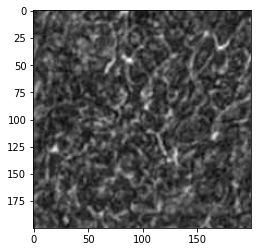

In [2]:
importlib.reload(ld)
config_path = '../config/config.json'
param_config_path = '../config/optimal_tile_params.json'

tiles, metadata = ld.get_all_lsc_images(get_tile=True, output_color = cv2.IMREAD_GRAYSCALE, config_path=config_path)
plt.imshow(tiles[0], cmap='gray');

In [3]:
tile_glcm = metadata.copy()
tile_glcm['contrast'] = 0.0
tile_glcm['energy'] = 0.0
for i, row in metadata.iterrows():
    tile = tiles[i]
    glcm = greycomatrix(tile, [10], [0], symmetric=True, normed=True)
    contrast = greycoprops(glcm, 'contrast')
    energy = greycoprops(glcm, 'energy')
    tile_glcm.loc[tile_glcm.index == i, ['contrast', 'energy']] = [contrast, energy]

In [4]:
tile_glcm.describe()

,image_num,contrast,energy
count,141.000000,141.000000,141.000000
mean,4.872340,130.962813,0.039913
std,2.848185,50.074223,0.006980
min,1.000000,53.044316,0.026725
25%,3.000000,93.612974,0.034910
50%,5.000000,126.130368,0.039023
75%,7.000000,154.017158,0.044225
max,16.000000,322.755737,0.061446


In [5]:
importlib.reload(ld)
images, img_metadata = ld.get_all_lsc_images(get_tile=False, output_color=cv2.IMREAD_UNCHANGED, config_path=config_path)

In [9]:
importlib.reload(st)
gen_tiles_glcm = pd.DataFrame()
tile_select_params = ld.get_tile_select_params(param_config_path)['LSC']
segmenter = st.TileSegmenter(
    **tile_select_params,
    plot_patches=False,
    show_tqdm=False,
)
for i, row in tqdm(img_metadata.iterrows(), desc='finding GLCM props on generated tiles', total=img_metadata.shape[0]):
    img = images[i]
    gen_tiles = segmenter.segment_tiles(img)
    for j, tile in enumerate(gen_tiles):
        img_rep = row.copy()
        if len(tile.shape) == 3:
            tile = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)
        glcm = greycomatrix(tile, [10], [0], symmetric=True, normed=True)
        img_rep['rep_n'] = j
        img_rep['contrast'] = greycoprops(glcm, 'contrast')[0][0]
        img_rep['energy'] = greycoprops(glcm, 'energy')[0][0]
        gen_tiles_glcm = gen_tiles_glcm.append(img_rep)
gen_tiles_glcm_save = gen_tile_glcm

finding GLCM props on generated tiles: 100%|██████████| 142/142 [08:17<00:00,  3.50s/it]


IndexError: invalid index to scalar variable.

In [10]:
gen_tiles_glcm.describe()

,contrast,energy,image_num,rep_n
count,426.000000,426.000000,426.000000,426.000000
mean,105.873045,0.042195,4.866197,1.000000
std,35.328162,0.006708,2.832323,0.817457
min,42.705868,0.025372,1.000000,0.000000
25%,81.197612,0.038020,3.000000,0.000000
50%,100.913934,0.041562,5.000000,1.000000
75%,122.626118,0.046300,7.000000,2.000000
max,255.169158,0.068089,16.000000,2.000000


In [11]:
merged = gen_tiles_glcm.merge(tile_glcm, on=['image_num', 'subject'], validate='m:1', suffixes=('_gen', '_gt'))
merged

,contrast_gen,energy_gen,image_num,rep_n,subject,contrast_gt,energy_gt
0,85.136474,0.044921,8.0,0.0,D3 R3,174.172184,0.033984
1,100.499921,0.042638,8.0,1.0,D3 R3,174.172184,0.033984
2,119.038132,0.039374,8.0,2.0,D3 R3,174.172184,0.033984
3,87.183368,0.046742,7.0,0.0,D3 R3,146.524158,0.037935
4,67.110184,0.055032,7.0,1.0,D3 R3,146.524158,0.037935
...,...,...,...,...,...,...,...
418,88.731053,0.045293,2.0,1.0,D1 R2,65.527895,0.054001
419,68.962447,0.049069,2.0,2.0,D1 R2,65.527895,0.054001
420,108.727789,0.040837,3.0,0.0,D1 R2,101.175316,0.042461
421,111.833579,0.040415,3.0,1.0,D1 R2,101.175316,0.042461


In [35]:
importlib.reload(st)
rand_tiles_glcm = pd.DataFrame()
rand_tile_select_params = ld.get_tile_select_params(param_config_path)['LSC']
rand_segmenter = st.TileSegmenter(
    **rand_tile_select_params,
    plot_patches=False,
    show_tqdm=False,
    random_tiles=True,
)
for i, row in tqdm(img_metadata.iterrows(), desc='finding GLCM props on generated tiles', total=img_metadata.shape[0]):
    img = images[i]
    gen_tiles = rand_segmenter.segment_tiles(img)
    for j, tile in enumerate(gen_tiles):
        img_rep = row.copy()
        if len(tile.shape) == 3:
            tile = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)
        glcm = greycomatrix(tile, [10], [0], symmetric=True, normed=True)
        img_rep['rep_n'] = j
        img_rep['contrast'] = greycoprops(glcm, 'contrast')[0][0]
        img_rep['energy'] = greycoprops(glcm, 'energy')[0][0]
        rand_tiles_glcm = rand_tiles_glcm.append(img_rep)
rand_tiles_glcm.describe()

finding GLCM props on generated tiles: 100%|██████████| 142/142 [06:01<00:00,  2.55s/it]


,contrast,energy,image_num,rep_n
count,426.000000,426.000000,426.000000,426.000000
mean,147.578954,0.038076,4.866197,1.000000
std,70.018181,0.008579,2.832323,0.817457
min,21.625816,0.021298,1.000000,0.000000
25%,95.554691,0.032099,3.000000,0.000000
50%,132.901487,0.037400,5.000000,1.000000
75%,185.121796,0.043208,7.000000,2.000000
max,397.844711,0.080232,16.000000,2.000000


In [37]:
rand_merged = rand_tiles_glcm.merge(tile_glcm, on=['image_num', 'subject'], validate='m:1', suffixes=('_gen', '_gt'))
rand_merged

,contrast_gen,energy_gen,image_num,rep_n,subject,contrast_gt,energy_gt
0,242.009132,0.029806,8.0,0.0,D3 R3,174.172184,0.033984
1,201.280000,0.031001,8.0,1.0,D3 R3,174.172184,0.033984
2,139.662421,0.035862,8.0,2.0,D3 R3,174.172184,0.033984
3,185.614579,0.032616,7.0,0.0,D3 R3,146.524158,0.037935
4,157.265789,0.036854,7.0,1.0,D3 R3,146.524158,0.037935
...,...,...,...,...,...,...,...
418,117.671316,0.041125,2.0,1.0,D1 R2,65.527895,0.054001
419,95.538763,0.044222,2.0,2.0,D1 R2,65.527895,0.054001
420,58.133842,0.054390,3.0,0.0,D1 R2,101.175316,0.042461
421,90.662737,0.042604,3.0,1.0,D1 R2,101.175316,0.042461


In [23]:
gen_tiles[0].shape

(101, 101, 3)

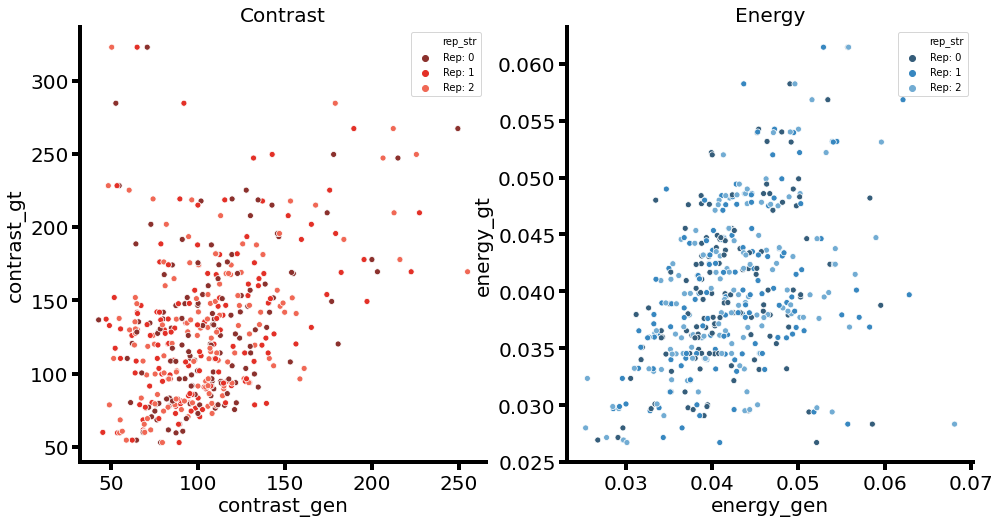

In [36]:
import src.format_axis as fa
importlib.reload(fa)

fig, axes = plt.subplots(ncols=2, figsize=(16,8))
merged['rep_str'] = merged['rep_n'].astype(int).astype(str)
merged['rep_str'] = 'Rep: ' + merged['rep_str']

sns.scatterplot(
    x='contrast_gen',
    y='contrast_gt',
    hue='rep_str',
    palette='Reds_d',
    data=merged,
    ax=axes[0]
)
axes[0].set_title('Contrast', fontsize=20)
sns.scatterplot(
    x='energy_gen',
    y='energy_gt',
    hue='rep_str',
    data=merged,
    ax=axes[1],
    palette='Blues_d'
)
axes[1].set_title('Energy', fontsize=20)

for axis in axes.flatten():
    fa.despine_thicken_axes(axis, fontsize=20)

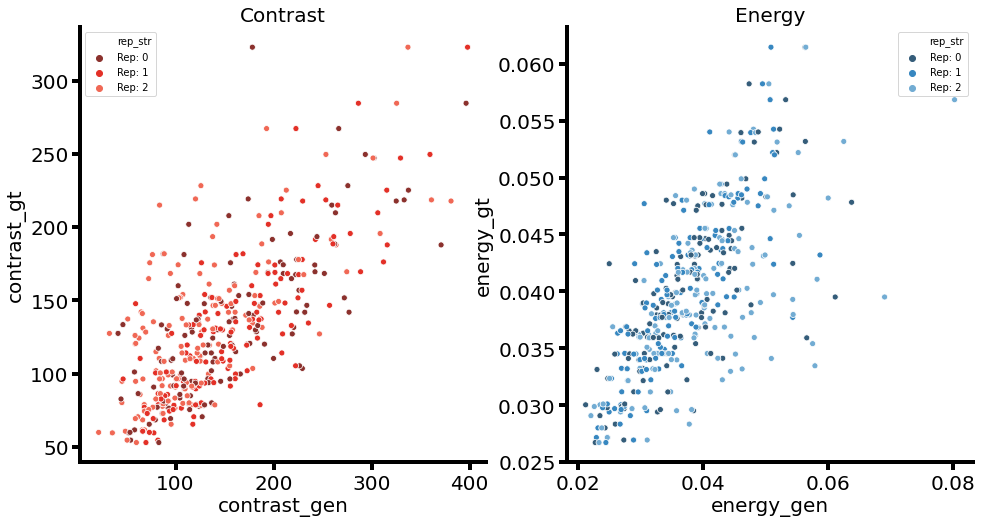

In [38]:

fig, axes = plt.subplots(ncols=2, figsize=(16,8))
rand_merged['rep_str'] = rand_merged['rep_n'].astype(int).astype(str)
rand_merged['rep_str'] = 'Rep: ' + rand_merged['rep_str']

sns.scatterplot(
    x='contrast_gen',
    y='contrast_gt',
    hue='rep_str',
    palette='Reds_d',
    data=rand_merged,
    ax=axes[0]
)
axes[0].set_title('Contrast', fontsize=20)
sns.scatterplot(
    x='energy_gen',
    y='energy_gt',
    hue='rep_str',
    data=rand_merged,
    ax=axes[1],
    palette='Blues_d'
)
axes[1].set_title('Energy', fontsize=20)

for axis in axes.flatten():
    fa.despine_thicken_axes(axis, fontsize=20)

In [49]:
contrast_corr = merged.groupby(['rep_str']).apply(lambda x: stats.pearsonr(x['contrast_gen'], x['contrast_gt'])[0])

,r,p
0,0.404897,6.357072e-07
1,0.424951,1.502709e-07
2,0.446314,2.907129e-08


In [53]:
rand_merged['exp_type'] = 'random'
merged['exp_type'] = 'optimized'
combined = pd.concat([rand_merged, merged])

energy_corr = combined.groupby(['rep_str', 'exp_type']).apply(lambda x: stats.pearsonr(x['energy_gen'], x['energy_gt']))
energy_corr_df = pd.DataFrame(energy_corr.tolist(), columns=['pearson_r', 'pearson_p'], index=energy_corr.index).reset_index()
contrast_corr = combined.groupby(['rep_str', 'exp_type']).apply(lambda x: stats.pearsonr(x['contrast_gen'], x['contrast_gt']))
contrast_corr_df = pd.DataFrame(contrast_corr.tolist(), columns=['pearson_r', 'pearson_p'], index=contrast_corr.index).reset_index()

energy_corr_df['glcm'] = 'energy'
contrast_corr_df['glcm'] = 'contrast'
glcm_df = pd.concat([energy_corr_df, contrast_corr_df])

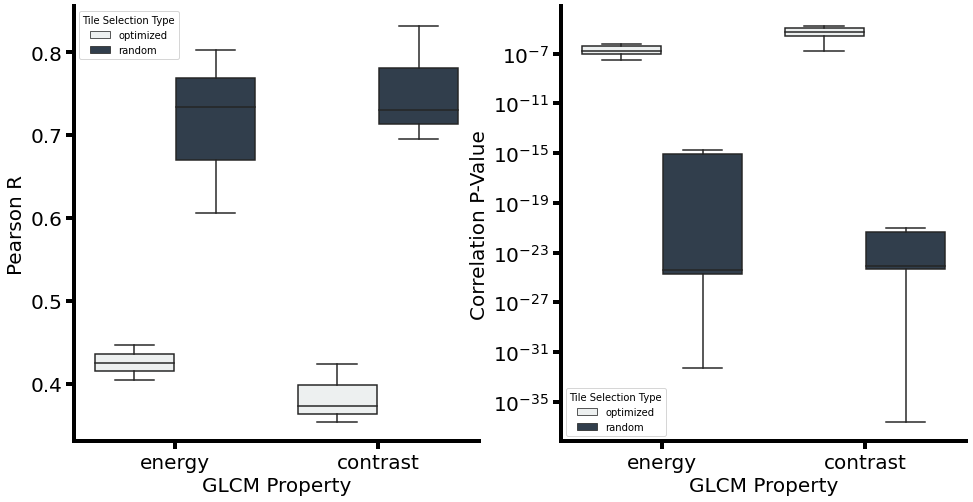

In [68]:

fig, axes = plt.subplots(ncols=2, figsize=(16,8))

sns.boxplot(
    x='glcm',
    y='pearson_r',
    hue='exp_type',
    data=glcm_df,
    ax=axes[0],
    palette=['#ecf0f1', '#2c3e50']
)
axes[0].legend(title='Tile Selection Type')
axes[0].set_ylabel('Pearson R')
axes[0].set_xlabel('GLCM Property')


axes[1].set_yscale('log')
sns.boxplot(
    x='glcm',
    y='pearson_p',
    hue='exp_type',
    data=glcm_df,
    ax=axes[1],
    palette=['#ecf0f1', '#2c3e50']
)
axes[1].legend(title='Tile Selection Type')
axes[1].set_ylabel('Correlation P-Value')
axes[1].set_xlabel('GLCM Property')
fa.despine_thicken_axes(axes[0], fontsize=20)
fa.despine_thicken_axes(axes[1], fontsize=20)